In [1]:
library(data.table)
library(dplyr)
library(tidyverse)
library(MuMIn)
library(MASS)
library(broom)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ readr   1.1.1
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ ggplot2 3.0.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



# 1.
Consider the situation in which the following regression model has been fit to a set of data

$Y = b_0 + b_1 x_1 + b_2 x_2 + b_3 x_3 + e$

Suppose that the hypothesis test based on Analysis of Variance leads to a strong rejection of the joint hypothesis that regression coefficients are all zero (p-value < 0.0001).  

Furthermore, suppose that each individual t-test of the form H0:  bi = 0 fails to reject the null for each value of i, where i=1,…,3.

Describe why this is likely to have occurred and what plots and which statistics you would look at to diagnose the problem. 



$x_1$, $x_2$, and $x_3$ are correlated with each other. While there is at least one coefficient that is not zero, non of the three are significantly different from zero in the presence of each other. We can confirm this with a scatterplot matrix and correlation coefficients. 

# 2.
Data taken from Howell (2002). 
“A number of years ago, the student association of a large university published an evaluation of several hundred courses taught during the preceding semester.  Students in each course had completed a questionnaire in which they rated a number of different aspects of the course on a 5-point scale (1 = very bad to 5 = excellent)”.

Five variables obtained were:
* overall – overall rating of the course.
* teach – rating of teaching skills of the instructor.
* exams – quality of tests and exams
* knowledge – rating of the instructor’s knowledge of the material 
* grade - student’s anticipated grade for the course (1=F to 5=A) 
* enroll – enrollment for the course

|overall|teach|exams|knowledge|grade|enroll|
|-----|------|------|---------|-----|------|
|3.4|3.8|3.8|4.5|3.5|21|
|2.9|2.8|3.2|3.8|3.2|50|
|2.6|2.2|1.9|3.9|2.8|800|
|3.8|3.5|3.5|4.1|3.3|221|
|3.0|3.2|2.8|3.5|3.2|7|
|2.5|2.7|3.8|4.2|3.2|108|
|3.9|4.1|3.8|4.5|3.6|54|
|4.3|4.2|4.1|4.7|4.0|99|
|3.8|3.7|3.6|4.1|3.0|51|
|3.4|3.7|3.6|4.1|3.1|47|
|3.4|3.8|3.8|4.5|3.5|21|
|2.8|3.3|3.5|3.9|3.0|73|
|2.9|2.2|3.3|3.9|3.3|25|
|4.1|4.1|3.6|4.0|3.2|37|
|2.7|3.1|3.8|4.1|3.4|83|
|3.9|2.9|3.8|4.5|3.7|70|

In [3]:
library(data.table)
data2 <- fread('https://raw.githubusercontent.com/wilsonify/AppliedRegression/master/data/howell.csv')

## a 
Enter the variables teach, exams, knowledge, grade, and enroll into a multiple regression model predicting scores for overall. Display the regression output. 

In [5]:
fit <- lm(data=data2, formula = overall~.)

summary_of_fit <- summary(fit)
summary_of_fit

## b
Create a table of R^2 adjusted, AIC, AICC, and BIC for the best subset of each size.

Identify the optimal model or models from the approach based on all possible subsets.

In [63]:
Xs <- c('teach','exams','knowledge','grade','enroll')
models <- c( interaction(Xs,            sep='+') %>% levels() %>% paste("overall ~",.)
            ,interaction(Xs,Xs,         sep='+') %>% levels() %>% paste("overall ~",.)
            ,interaction(Xs,Xs,Xs,      sep='+') %>% levels() %>% paste("overall ~",.)
            ,interaction(Xs,Xs,Xs,Xs,   sep='+') %>% levels() %>% paste("overall ~",.)
            ,interaction(Xs,Xs,Xs,Xs,Xs,sep='+') %>% levels() %>% paste("overall ~",.)   
           )

In [78]:
AICc_from_AIC <- function(AIC,fit) {    
    n <- length(fit$residuals)  
    k <- length(fit$coefficients) - 1    
    correction <- (2*k^2 + 2*k) / (n - k - 1)
    return ( AIC + correction )
}

result <- data_frame()
for (form in models) {
    #print(form)
    fit <- lm(data=data2, formula = as.formula(form))        
    glance_of_fit <- glance(fit) %>%
                     mutate( model=form
                            ,k = length(fit$coefficients) - 1   
                            ,AICc = AICc_from_AIC(AIC,fit)) %>% 
                     dplyr::select(c( 'model' 
                                     ,'k'
                                     ,'adj.r.squared'
                                     ,'AIC'
                                     ,'AICc'
                                     ,'BIC')
                                  )
    result <- rbind(result,glance_of_fit)
}

In [93]:
result %>% group_by(k) %>% summarise( max(adj.r.squared)
                                     ,min(AIC)
                                     ,min(AICc)
                                     ,min(BIC)
                                    )

k,max(adj.r.squared),min(AIC),min(AICc),min(BIC)
1,0.5640442,18.56408,18.87178,20.68823
2,0.6181954,17.37396,18.37396,20.20616
3,0.6068139,18.50940,20.69122,22.04965
4,0.5838749,19.93029,23.93029,24.17859
5,0.5405103,21.83684,28.50351,26.79320


In [86]:
result[which.max(result$adj.r.squared),]
result[which.min(result$AIC),]
result[which.min(result$AICc),]
result[which.min(result$BIC),]

model,k,adj.r.squared,AIC,AICc,BIC
overall ~ teach+grade,2,0.6181954,17.37396,18.37396,20.20616


model,k,adj.r.squared,AIC,AICc,BIC
overall ~ grade+teach,2,0.6181954,17.37396,18.37396,20.20616


model,k,adj.r.squared,AIC,AICc,BIC
overall ~ grade+teach,2,0.6181954,17.37396,18.37396,20.20616


model,k,adj.r.squared,AIC,AICc,BIC
overall ~ teach+grade,2,0.6181954,17.37396,18.37396,20.20616


## c
Use the Forward method to determine the regression equation when starting with the same predictor variables listed in a. Please describe the steps R went through in generating its regression equation.

At each stage of the process list the variable that was entered or removed from the equation and the R Square for the regression equation up to that point.

Report the final version of the regression equation.

In [87]:
minimal.model <- lm(overall ~ 1, data = data2)
forward.step.model <- stepAIC( minimal.model
                      ,direction = "forward"
                      ,scope = list(upper = ~ teach+exams+knowledge+grade+enroll
                                   ,lower = ~ 1)
                      ,trace = TRUE)
summary(forward.step.model )

Start:  AIC=-14.44
overall ~ 1

            Df Sum of Sq    RSS     AIC
+ teach      1   2.98386 2.0295 -26.004
+ knowledge  1   1.73097 3.2824 -18.792
+ grade      1   1.68492 3.3284 -18.583
+ exams      1   1.26642 3.7469 -16.807
<none>                   5.0133 -14.439
+ enroll     1   0.42414 4.5892 -13.765

Step:  AIC=-26
overall ~ teach

            Df Sum of Sq    RSS     AIC
+ grade      1   0.38881 1.6407 -27.194
+ knowledge  1   0.29895 1.7305 -26.394
<none>                   2.0295 -26.004
+ enroll     1   0.01496 2.0145 -24.115
+ exams      1   0.01217 2.0173 -24.094

Step:  AIC=-27.19
overall ~ teach + grade

            Df Sum of Sq    RSS     AIC
<none>                   1.6407 -27.194
+ enroll     1  0.091890 1.5488 -26.059
+ exams      1  0.091096 1.5496 -26.051
+ knowledge  1  0.024660 1.6160 -25.421



Call:
lm(formula = overall ~ teach + grade, data = data2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57599 -0.28129 -0.04803  0.28262  0.56055 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.6029     1.0757  -0.561  0.58543   
teach         0.5888     0.1676   3.513  0.00427 **
grade         0.6041     0.3582   1.686  0.11753   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3698 on 12 degrees of freedom
Multiple R-squared:  0.6727,	Adjusted R-squared:  0.6182 
F-statistic: 12.33 on 2 and 12 DF,  p-value: 0.001228


Forward selection process:
1. starting with the null model.
2. fit a separate model adding each potential new feature.
3. select the model which minimizes AIC.
4. repeat 2-3 until AIC cannot be lowered.

## d
Repeat Part c, except use the Backward method (i.e., describe each step R went through).

Is the solution different from the one you got using the Forward method? 

In [88]:
maximal.model <- lm(overall ~ ., data = data2)
backward.step.model <- stepAIC( maximal.model
                              ,direction = "backward"
                              ,scope = list(upper = ~ teach+exams+knowledge+grade+enroll
                                            ,lower = ~ 1)
                              ,trace = TRUE)
summary(backward.step.model )

Start:  AIC=-22.73
overall ~ teach + exams + knowledge + grade + enroll

            Df Sum of Sq    RSS     AIC
- enroll     1   0.00925 1.4901 -24.638
- knowledge  1   0.04830 1.5292 -24.250
- exams      1   0.06717 1.5480 -24.066
- grade      1   0.11473 1.5956 -23.612
<none>                   1.4809 -22.731
- teach      1   1.44946 2.9303 -14.494

Step:  AIC=-24.64
overall ~ teach + exams + knowledge + grade

            Df Sum of Sq    RSS     AIC
- knowledge  1   0.05945 1.5496 -26.051
- exams      1   0.12588 1.6160 -25.421
- grade      1   0.18768 1.6778 -24.858
<none>                   1.4901 -24.638
- teach      1   1.54723 3.0374 -15.956

Step:  AIC=-26.05
overall ~ teach + exams + grade

        Df Sum of Sq    RSS     AIC
- exams  1   0.09110 1.6407 -27.194
<none>               1.5496 -26.051
- grade  1   0.46773 2.0173 -24.094
- teach  1   1.66039 3.2100 -17.127

Step:  AIC=-27.19
overall ~ teach + grade

        Df Sum of Sq    RSS     AIC
<none>               1.6407 -27


Call:
lm(formula = overall ~ teach + grade, data = data2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57599 -0.28129 -0.04803  0.28262  0.56055 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.6029     1.0757  -0.561  0.58543   
teach         0.5888     0.1676   3.513  0.00427 **
grade         0.6041     0.3582   1.686  0.11753   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3698 on 12 degrees of freedom
Multiple R-squared:  0.6727,	Adjusted R-squared:  0.6182 
F-statistic: 12.33 on 2 and 12 DF,  p-value: 0.001228


Backward selection process:
1. starting with the full model.
2. fit a separate model removing each potential feature.
3. select the model which minimizes AIC.
4. repeat 2-3 until AIC cannot be lowered.

In this case, forward and backward selection agree on the best model as overal ~ teach+grade

## e
Decide on the model you would recommend.

At this point, describe and examine the assumptions of multiple linear regression.

If any assumptions are violated -- discuss what steps would/should be performed.

overall ~ teach + grade
is best model because it maximizes R^2 while minimzing AIC, AICc, and BIC.

In [94]:
fit <- lm(data=data2, formula = overall~teach + grade)
summary_of_fit <- summary(fit)
summary_of_fit


Call:
lm(formula = overall ~ teach + grade, data = data2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57599 -0.28129 -0.04803  0.28262  0.56055 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.6029     1.0757  -0.561  0.58543   
teach         0.5888     0.1676   3.513  0.00427 **
grade         0.6041     0.3582   1.686  0.11753   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3698 on 12 degrees of freedom
Multiple R-squared:  0.6727,	Adjusted R-squared:  0.6182 
F-statistic: 12.33 on 2 and 12 DF,  p-value: 0.001228


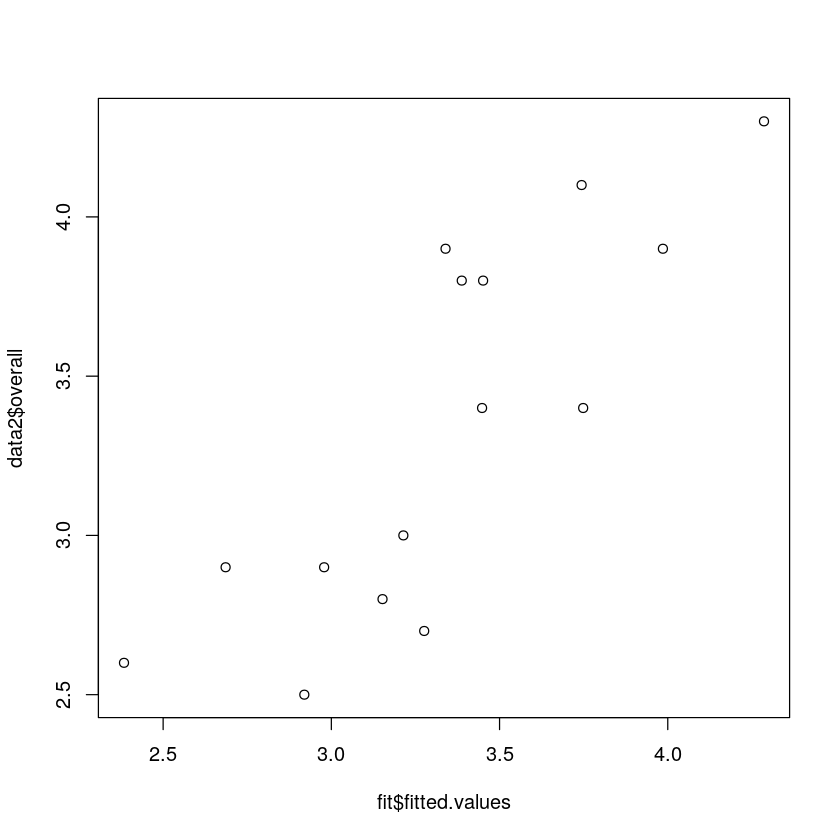

In [97]:
plot(fit$fitted.values,data2$overall)

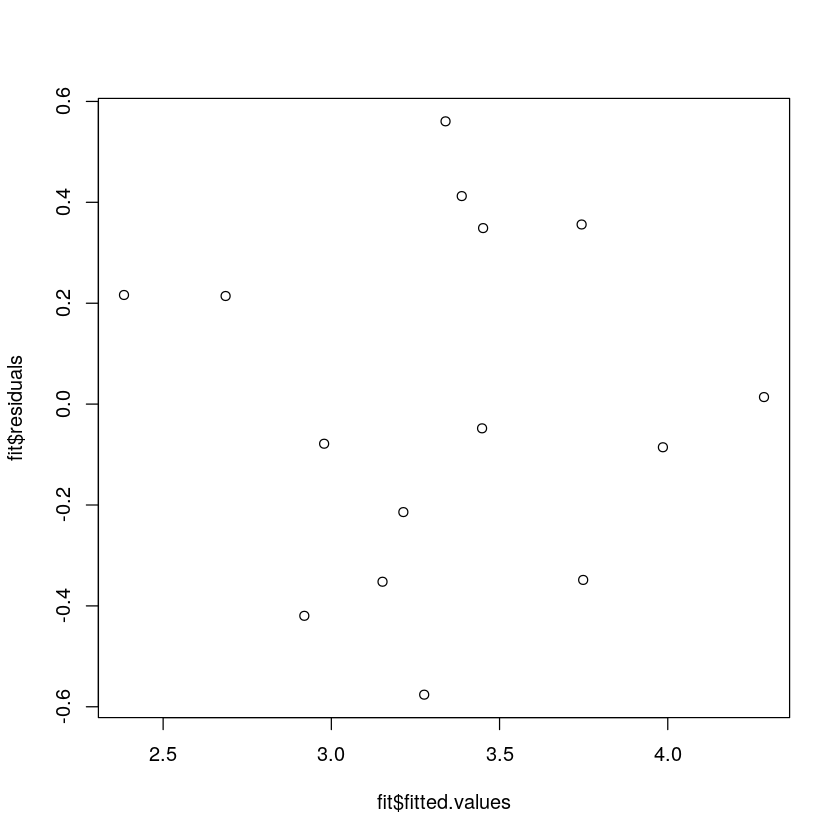

In [96]:
plot(y=fit$residuals,x=fit$fitted.values)

In [98]:
studentized_residuals <- studres(fit)

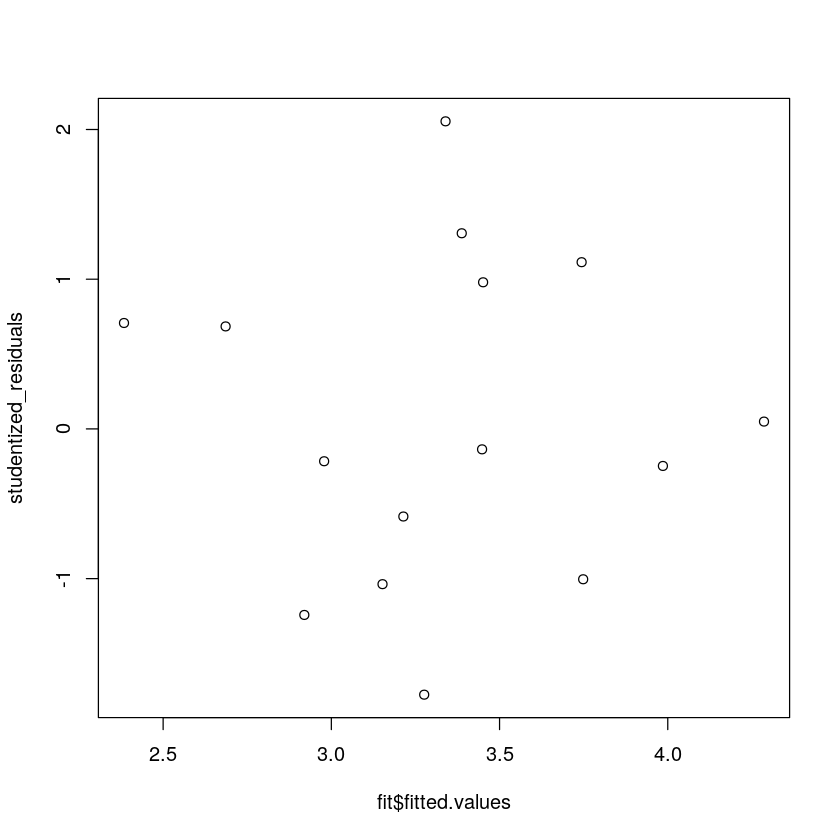

In [99]:
plot(y=studentized_residuals,x=fit$fitted.values)

We consider modeling Credit Card Balances.

Data are available on Balances and the following potential predictor variables:
1. Income
2. Limit
3. Rating
4. Cards (Number of Credit Cards)
5. Age (Years)
6. Education (Years)
7. Student (1=Student and 0=Non-student)

Use R to do the following tasks.

Copy the data in excel and run the following syntax
my_data <- read.table(file = "clipboard", sep = "\t", header=TRUE)

Paste the numerical output and plots into a Word document.

In [110]:
data3 <- fread('https://raw.githubusercontent.com/wilsonify/AppliedRegression/master/data/CreditCardsTraining.csv')

In [111]:
data3

Title,MajorStudio,Runtime,Rating,Production Budget (in millions),In Release,Widest Release,Opening Weekend Gross,Total Gross,Critic Rating,Audience Rating,Year,MonthOfRelease,LogOpeningWeekendGross,LogProductionBudget,LogWidestRelease,LogTotalGross
Toy Story 3,1,103,G,200,168,4028,110307189,415004880,99,89,2010,6,18.51878,19.11383,8.301025,19.84380
Alice in Wonderland (2010),1,109,PG,200,126,3739,116101023,334191110,51,55,2010,3,18.56997,19.11383,8.226573,19.62722
Iron Man 2,1,125,PG-13,200,104,4390,128122480,312433331,73,73,2010,5,18.66850,19.11383,8.387085,19.55990
The Twilight Saga: Eclipse,0,124,PG-13,68,114,4468,64832191,300531751,49,60,2010,6,17.98731,18.03502,8.404696,19.52106
Harry Potter and the Deathly Hallows Part 1,1,150,PG-13,125,139,4125,125017372,295983305,78,84,2010,11,18.64396,18.64382,8.324821,19.50581
Inception,1,148,PG-13,160,175,3792,62785337,292576195,86,91,2010,7,17.95523,18.89068,8.240649,19.49424
Despicable Me,1,95,PG,69,196,3602,56397125,251513985,81,82,2010,7,17.84793,18.04962,8.189245,19.34301
Shrek Forever After,1,93,PG,165,112,4386,70838207,238736787,58,54,2010,5,18.07591,18.92146,8.386173,19.29087
How to Train Your Dragon,1,98,PG,165,119,4060,43732319,217581231,98,91,2010,3,17.59360,18.92146,8.308938,19.19808
Tangled,1,100,PG,260,191,3603,48767052,200821936,89,87,2010,11,17.70257,19.37619,8.189522,19.11793


## a
Fit a model to predict Income from Limit, Rating, Cards, Age, Education, and Student.  Please do not include any quadratic nor any interaction terms.  Ensure that you find the variance inflation factors (VIF).

In [ ]:
data3$
fit <- lm(formula = ,data = data3)

## b
Plot the studentized residuals against the predicted values and each numerical predictor.

## c
Plot the numerical predictors against each other and obtain the correlations amongst these predictors.

On the basis of the output you produced in (a), (b), and (c) answer the following questions:

	
## I
Decide whether the assumption of constant error variance is a reasonable one for the fitted model.  Give reasons to support your answer.

## II
Decide whether multicollinearity is an issue for the fitted model. Give a reason to support your answer.

## III
Interpret the estimated coefficients. Decide whether these coefficients are statistically significant. Give a reason to support your answer.